# Time Series Forecasting

In [1]:
!pip install yfinance

In [2]:
import pandas as pd
import yfinance as yf

/usr/local/lib/python3.10/dist-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


In [3]:
### If you are using colab, you can import google drive to save model checkpoints in a folder
from google.colab import drive
drive.mount('/content/drive/')
GDRIVE_PROJECT_PATH = '/content/drive/MyDrive/Colab-Notebooks/NLP'

Mounted at /content/drive/


In [4]:
# Fetching GameStop's stock data
df = yf.download('GME', start='2021-01-04', end='2021-12-31')
df = df.reset_index()

[*********************100%%**********************]  1 of 1 completed


In [5]:
df.shape

(251, 7)

In [6]:
df.tail(10)

,Date,Open,High,Low,Close,Adj Close,Volume
241,2021-12-16,38.232498,38.610001,35.532501,36.147499,36.147499,8659200
242,2021-12-17,35.937500,39.642502,34.832500,38.910000,38.910000,17226800
243,2021-12-20,38.297501,39.919998,37.424999,39.285000,39.285000,7314400
244,2021-12-21,39.264999,40.062500,38.785000,39.529999,39.529999,5720800
245,2021-12-22,39.582500,39.787498,38.029999,38.500000,38.500000,4188800
246,2021-12-23,38.500000,38.750000,36.505001,38.035000,38.035000,4222000
247,2021-12-27,38.000000,38.154999,35.000000,37.077499,37.077499,6454400
248,2021-12-28,36.875000,39.352501,36.602501,36.615002,36.615002,5324400
249,2021-12-29,36.962502,38.872501,35.535000,38.482498,38.482498,8149600
250,2021-12-30,37.750000,40.000000,37.500000,38.832500,38.832500,6247600


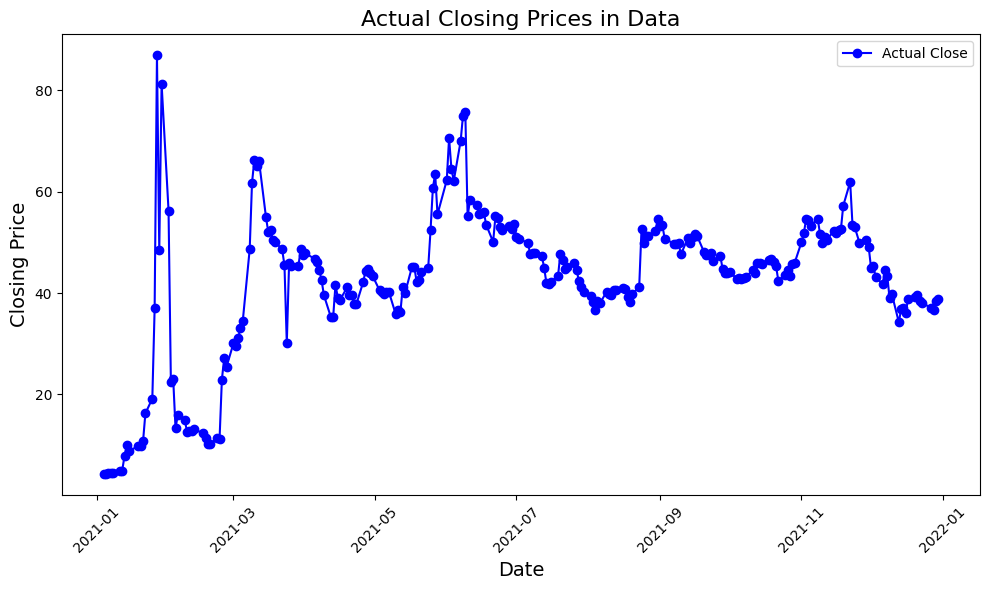

In [7]:
import matplotlib.pyplot as plt


# Ensure the 'Date' column is in datetime format for proper plotting
df['Date'] = pd.to_datetime(df['Date'])

# Setting the plot size for better readability
plt.figure(figsize=(10, 6))

# Plotting the actual closing prices in the training period
plt.plot(df['Date'], df['Close'], label='Actual Close', color='blue', marker='o')

# Adding title and labels with font size adjustments
plt.title('Actual Closing Prices in Data', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Closing Price', fontsize=14)

# Rotating date labels for better visibility
plt.xticks(rotation=45)

# Adding a legend to distinguish the actual values
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()

In [8]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
from datetime import datetime, timedelta



In [9]:
# Convert 'Date' to datetime and sort the DataFrame just in case
df['Date'] = pd.to_datetime(df['Date']) # This line converts the 'Date' column of the DataFrame df to datetime objects.
df.sort_values('Date', inplace=True)
#  The .values attribute returns the data as a NumPy array. The .reshape(-1, 1) function changes
#  the shape of this array to ensure it has two dimensions, with one column and as many rows as necessary.
close_prices = df['Close'].values.reshape(-1, 1)
# Scale the data -> you can use any appropriate scaling methodology
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_close_prices = scaler.fit_transform(close_prices)

In [10]:
scaled_close_prices.shape

(251, 1)

In [11]:
# Function to create sequences
def create_sequences(data, sequence_length):
    xs, ys = [], []
    for i in range(len(data) - sequence_length):
        x = data[i:(i + sequence_length)]
        y = data[i + sequence_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

In [12]:
SEQUENCE_LENGTH = 20  # You can adjust this value -> parameter tuning
X, y = create_sequences(scaled_close_prices, SEQUENCE_LENGTH)

In [13]:
print(X.shape)
print(y.shape)

(231, 20, 1)
(231, 1)


In [14]:
# Split the data into training and test sets (train on data until May 31st)
TRAIN_END_DATE = '2021-05-31'
train_indices = df[df['Date'] <= TRAIN_END_DATE].index
X_train, y_train = X[:train_indices[-1]-SEQUENCE_LENGTH], y[:train_indices[-1]-SEQUENCE_LENGTH]

In [15]:
print(X_train.shape, y_train.shape)

(81, 20, 1) (81, 1)



The model described is a neural network architecture using Long Short-Term Memory (LSTM) layers, commonly employed for sequence prediction problems such as time series forecasting. Here's a breakdown of each component of the model:

1. LSTM Layer with return_sequences=True
LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)):
This is the first layer in the model and an LSTM layer with 50 units. LSTM units are a type of recurrent neural network (RNN) cell that are effective in capturing long-term dependencies in sequence data.
return_sequences=True indicates that this layer returns the full sequence of outputs for each sample. This is necessary when stacking LSTM layers so that the subsequent LSTM layer can receive sequences of data as input.
input_shape=(X_train.shape[1], 1) specifies the shape of the input data. In this context, X_train.shape[1] refers to the sequence length (number of time steps), and 1 refers to the number of features per time step. This model is configured to work with a single feature per time step, typical for univariate time series forecasting (e.g., predicting a stock price based on past values of the stock price alone).


2. LSTM Layer with return_sequences=False
LSTM(50, return_sequences=False):
This is the second LSTM layer in the model, also with 50 units.
return_sequences=False means this layer only returns the output for the last time step in the input sequence. This is used when the subsequent layer expects a single vector per sample rather than a sequence of vectors. Since the next layer is a dense layer (fully connected layer), only the final output of the LSTM is needed.
This layer serves to further process the information extracted by the first LSTM layer, focusing on extracting features that will be useful for the final prediction.


3. Dense Layer
Dense(1):
This is a fully connected layer that follows the LSTM layers. It has a single unit.
The purpose of this layer is to output a single value, which is the predicted value for the next time step in the sequence. For example, in stock price prediction, this would be the predicted stock price for the next day.
Since this model is likely intended for regression (predicting a continuous value), there's no activation function specified, implying a linear activation is used by default. This allows the model to output values in the range of the real numbers.

In [16]:
# Define the LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    LSTM(50, return_sequences=False),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=20, batch_size=32)

Epoch 1/20
3/3 [==============================] - 4s 21ms/step - loss: 0.1444
Epoch 2/20
3/3 [==============================] - 0s 20ms/step - loss: 0.0537
Epoch 3/20
3/3 [==============================] - 0s 21ms/step - loss: 0.0286
Epoch 4/20
3/3 [==============================] - 0s 19ms/step - loss: 0.0393
Epoch 5/20
3/3 [==============================] - 0s 18ms/step - loss: 0.0243
Epoch 6/20
3/3 [==============================] - 0s 19ms/step - loss: 0.0248
Epoch 7/20
3/3 [==============================] - 0s 19ms/step - loss: 0.0282
Epoch 8/20
3/3 [==============================] - 0s 20ms/step - loss: 0.0261
Epoch 9/20
3/3 [==============================] - 0s 19ms/step - loss: 0.0229
Epoch 10/20
3/3 [==============================] - 0s 19ms/step - loss: 0.0220
Epoch 11/20
3/3 [==============================] - 0s 22ms/step - loss: 0.0227
Epoch 12/20
3/3 [==============================] - 0s 18ms/step - loss: 0.0222
Epoch 13/20
3/3 [==============================] - 0s 19ms/st

In [17]:
business_days = pd.date_range(start=pd.to_datetime(TRAIN_END_DATE) + timedelta(days=1),
                              periods=66, freq='B')

In [18]:
business_days

DatetimeIndex(['2021-06-01', '2021-06-02', '2021-06-03', '2021-06-04',
               '2021-06-07', '2021-06-08', '2021-06-09', '2021-06-10',
               '2021-06-11', '2021-06-14', '2021-06-15', '2021-06-16',
               '2021-06-17', '2021-06-18', '2021-06-21', '2021-06-22',
               '2021-06-23', '2021-06-24', '2021-06-25', '2021-06-28',
               '2021-06-29', '2021-06-30', '2021-07-01', '2021-07-02',
               '2021-07-05', '2021-07-06', '2021-07-07', '2021-07-08',
               '2021-07-09', '2021-07-12', '2021-07-13', '2021-07-14',
               '2021-07-15', '2021-07-16', '2021-07-19', '2021-07-20',
               '2021-07-21', '2021-07-22', '2021-07-23', '2021-07-26',
               '2021-07-27', '2021-07-28', '2021-07-29', '2021-07-30',
               '2021-08-02', '2021-08-03', '2021-08-04', '2021-08-05',
               '2021-08-06', '2021-08-09', '2021-08-10', '2021-08-11',
               '2021-08-12', '2021-08-13', '2021-08-16', '2021-08-17',
      

In [19]:
# Get the last sequence from the training data
last_sequence = X_train[-1].reshape((1, SEQUENCE_LENGTH, 1))

In [20]:
# Create a list to hold predictions
predictions = []

# Predict future prices
for i in range(len(business_days)):
    # Get the prediction (scaled value)
    current_prediction = model.predict(last_sequence)[0]

    # Append the prediction
    predictions.append(current_prediction)

    # Update the sequence
    last_sequence = np.roll(last_sequence, -1, axis=1)
    last_sequence[0, -1, 0] = current_prediction

# Inverse transform the predictions to get actual values
predicted_prices = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

# Create a DataFrame with the predicted stock prices and dates
predictions_df = pd.DataFrame({
    'Date': business_days,
    'Predicted_Close': predicted_prices.flatten()
})

# Show the prediction results
print(predictions_df)

1/1 [==============================] - 0s 27ms/step


<ipython-input-20-91cef6e19487>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  last_sequence[0, -1, 0] = current_prediction


1/1 [==============================] - 0s 21ms/step
         Date  Predicted_Close
0  2021-06-01        43.176941
1  2021-06-02        43.716347
2  2021-06-03        43.983902
3  2021-06-04        44.091000
4  2021-06-07        44.095661
..        ...              ...
61 2021-08-25        41.177242
62 2021-08-26        41.170567
63 2021-08-27        41.164272
64 2021-08-30        41.158344
65 2021-08-31        41.152763

[66 rows x 2 columns]


In [21]:
# Continue from the previous predictions_df creation code

# Ensure the 'Date' columns in both DataFrames are in the same format
df['Date'] = pd.to_datetime(df['Date'])
predictions_df['Date'] = pd.to_datetime(predictions_df['Date'])

# Merge the predictions with the actual closing prices from 'df'
predictions_with_actuals_df = predictions_df.merge(df[['Date', 'Close']], on='Date', how='left')

# Rename columns for clarity
predictions_with_actuals_df.rename(columns={'Close': 'Actual_Close'}, inplace=True)

# Show the DataFrame with predictions and actual closing prices
print(predictions_with_actuals_df)

         Date  Predicted_Close  Actual_Close
0  2021-06-01        43.176941     62.255001
1  2021-06-02        43.716347     70.559998
2  2021-06-03        43.983902     64.544998
3  2021-06-04        44.091000     62.090000
4  2021-06-07        44.095661     70.002502
..        ...              ...           ...
61 2021-08-25        41.177242     49.912498
62 2021-08-26        41.170567     51.305000
63 2021-08-27        41.164272     51.237499
64 2021-08-30        41.158344     52.299999
65 2021-08-31        41.152763     54.560001

[66 rows x 3 columns]


In [22]:
# Continue from the previous predictions_df creation code

# Ensure the 'Date' columns in both DataFrames are in the same format
df['Date'] = pd.to_datetime(df['Date'])
predictions_df['Date'] = pd.to_datetime(predictions_df['Date'])

# Merge the predictions with the actual closing prices from 'df'
predictions_with_actuals_df = predictions_df.merge(df[['Date', 'Close']], on='Date', how='left')

# Rename columns for clarity
predictions_with_actuals_df.rename(columns={'Close': 'Actual_Close'}, inplace=True)

# Show the DataFrame with predictions and actual closing prices
print(predictions_with_actuals_df)

         Date  Predicted_Close  Actual_Close
0  2021-06-01        43.176941     62.255001
1  2021-06-02        43.716347     70.559998
2  2021-06-03        43.983902     64.544998
3  2021-06-04        44.091000     62.090000
4  2021-06-07        44.095661     70.002502
..        ...              ...           ...
61 2021-08-25        41.177242     49.912498
62 2021-08-26        41.170567     51.305000
63 2021-08-27        41.164272     51.237499
64 2021-08-30        41.158344     52.299999
65 2021-08-31        41.152763     54.560001

[66 rows x 3 columns]


In [23]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Ensure both the actuals and predictions are aligned in time
predictions_with_actuals_df.dropna(inplace=True)

# Calculate MSE
mse = mean_squared_error(predictions_with_actuals_df['Actual_Close'], predictions_with_actuals_df['Predicted_Close'])

# Calculate RMSE
rmse = np.sqrt(mse)

# Calculate MAE
mae = mean_absolute_error(predictions_with_actuals_df['Actual_Close'], predictions_with_actuals_df['Predicted_Close'])

print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")


MSE: 118.95302946623706
RMSE: 10.906559011266435
MAE: 7.987151688795823


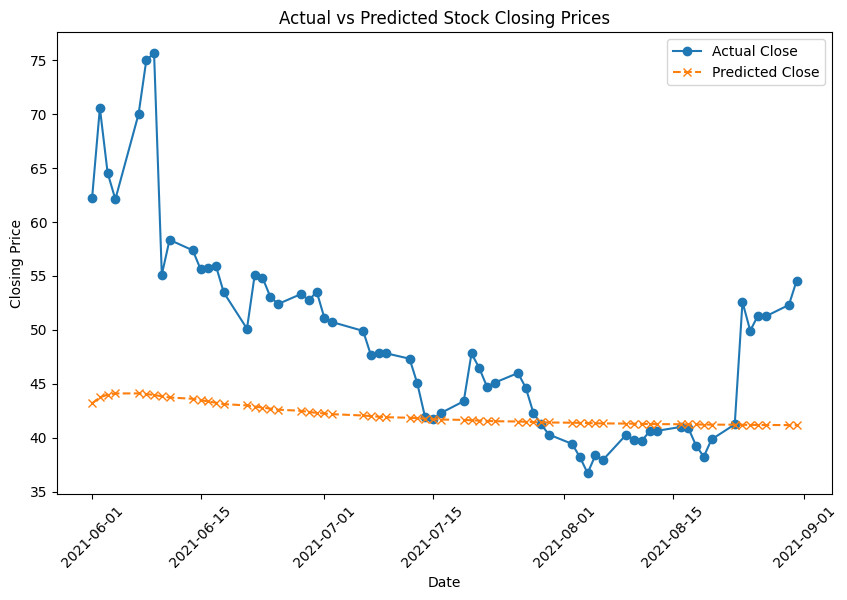

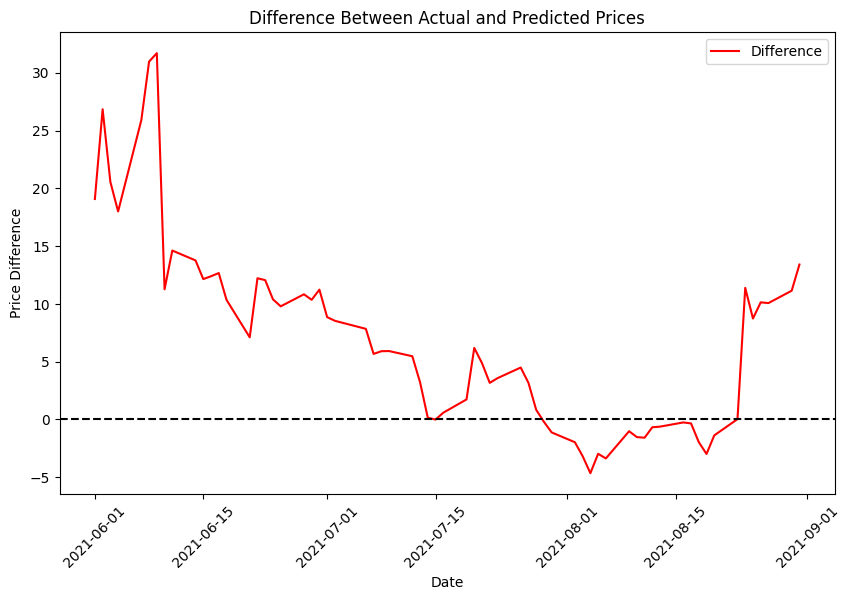

In [24]:
# Plot Actual vs. Predicted Prices
plt.figure(figsize=(10, 6))
plt.plot(predictions_with_actuals_df['Date'], predictions_with_actuals_df['Actual_Close'], label='Actual Close', marker='o')
plt.plot(predictions_with_actuals_df['Date'], predictions_with_actuals_df['Predicted_Close'], label='Predicted Close', linestyle='--', marker='x')
plt.title('Actual vs Predicted Stock Closing Prices')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.xticks(rotation=45)
plt.legend()
plt.show()

# Plotting the differences
plt.figure(figsize=(10, 6))
plt.plot(predictions_with_actuals_df['Date'], predictions_with_actuals_df['Actual_Close'] - predictions_with_actuals_df['Predicted_Close'], label='Difference', color='red')
plt.title('Difference Between Actual and Predicted Prices')
plt.xlabel('Date')
plt.ylabel('Price Difference')
plt.axhline(y=0, color='black', linestyle='--')
plt.xticks(rotation=45)
plt.legend()
plt.show()


Based on the graph and the numerical findings above for the predicted versus actual closing prices of GameStop stock, here's my analysis:

1. **My Observation of Trends**:
   - The actual closing prices, represented by the blue line, exhibit considerable volatility, with distinct spikes and drops.
   - In contrast, my predicted closing prices, shown by the orange dashed line, are markedly consistent and fail to reflect the volatility inherent in the actual prices.
   - The predictions I've generated seem to remain within a narrow band and don't replicate the dynamic highs and lows presented in the real data.

2. **My Understanding of the Discrepancies**:
   - **Model Sensitivity**: It seems that the model I used isn't adequately sensitive to sudden stock price movements. Although LSTM models leverage historical data to discern trends, they may not effectively respond to abrupt market shifts unless they're specifically trained to recognize such anomalies.
   - **Feature Selection**: The features I chose for the model might not be capturing the factors that influence price fluctuations. If I didn't include features like trading volume or news sentiment, the model's predictive power would naturally be limited.
   - **Training Data Considerations**: If the training period for my model didn't encompass data from events similar to the GameStop short squeeze, which was quite an unusual market occurrence, then it wouldn't capture such extraordinary movements.
   - **Data Preprocessing Decisions**: The manner in which I preprocessed the data before feeding it to the model could significantly affect the outcomes. Inadequate scaling or loss of critical information during preprocessing could impair the model's ability to predict accurately.
   - **Hyperparameter Tuning**: There are many hyperparameters within an LSTM model that I need to fine-tune. If these haven't been optimized, it could lead to the model's inability to grasp the data's intricacies.
   - **Market Dynamics**: The fluctuations in GameStop's stock were driven by factors beyond usual market indicators, like the collective actions of retail investors. Such complex social dynamics are notoriously difficult to predict using traditional quantitative models unless elements like social media sentiment are integrated.
   - **Model Fit**: The model might be underfitting the data, which suggests that it's too simplistic to capture the underlying market patterns. This is evidenced by the prediction line's lack of responsiveness to the market's fluctuations.

3. **Ways I Can Address These Issues**:
   - **Enhancing Feature Engineering**: I would look into including more pertinent features that could encompass market sentiment, social media trends, and other external factors influencing stock volatility.
   - **Optimizing Hyperparameters**: I would employ cross-validation and grid search methods to identify the best hyperparameters for my model.
   - **Adjusting Model Complexity**: To better capture market volatility, I would consider increasing the complexity of my model by adding more layers or neurons, or experimenting with different types of neural networks that are known for handling volatility, like Gated Recurrent Units (GRUs) or a hybrid model that combines LSTM with convolutional layers.
   - **Incorporating Sentiment Analysis**: Given the impact of sentiment on GameStop's price, I'd integrate sentiment analysis from social platforms to provide additional context for the model.
   - **Implementing Anomaly Detection**: I would introduce a mechanism to detect anomalies or sudden shifts in stock price data, which could then be factored into the predictions.

I would go with incorporting Sentiment Analysis into the model and then build a fused model to see if it makes the predicted outcomes closer to actual outcomes.

# Sentiment Analysis and Model Fusion

In [25]:
reddit_comments_df = pd.read_csv(GDRIVE_PROJECT_PATH + '/reddit.csv')


<ipython-input-25-4b41a21fd2d3>:1: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  reddit_comments_df = pd.read_csv(GDRIVE_PROJECT_PATH + '/reddit.csv')


In [26]:
reddit_comments_df.sample(6)

,Unnamed: 0,id,title,url,score,author,num_comments,date,flair,compound,...,_poss,_intj,_appos,_npadvmod,_predet,_case,_expl,_oprd,_dative,_nmod
927685,927685,nlx0o1,HODL &amp; 👋,https://www.reddit.com/r/GME/comments/nlx0o1/h...,1.0,OGTerminator69,2.0,2021-05-26,💎 🙌,0.4939,...,0,0,0,0,0,0,0,0,0,0
803887,803887,mmxacx,OUR CHAIRMAN,https://twitter.com/ryancohen/status/138021295...,1.0,JamesOfHanen,0.0,2021-04-08,💎🙌,0.0000,...,1,0,0,0,0,0,0,0,0,0
144289,144289,m6qs1y,Explaining to my buddy why he shouldn’t sell h...,https://i.redd.it/l678plgd9in61.jpg,1.0,p3p3_sylvia,5.0,2021-03-16,Memes 🤣,0.0000,...,2,0,0,1,0,0,0,0,0,0
864687,864687,n188ks,*Leaked* r/GME Shill Management Training Video...,https://youtu.be/rkqBg2L-9t0,1.0,RatioAtBlessons,5.0,2021-04-29,☁️ Fluff 🍌,-0.3182,...,0,0,0,0,0,0,0,0,0,1
400091,400091,m6qt1c,BUYING MORE SHARES - DO OR BAN - My insolence ...,https://www.reddit.com/r/GME/comments/m6qt1c/b...,1.0,StarMeasures08,0.0,2021-03-16,NaN,-0.1695,...,1,0,0,0,0,0,0,0,0,0
351646,351646,m6r9xp,I'm gonna try to share this youtube video doc ...,https://www.reddit.com/r/GME/comments/m6r9xp/i...,1.0,_XBlueFalconX_,1.0,2021-03-16,Fluff,0.7430,...,0,0,0,0,1,0,0,0,0,0


In [27]:
reddit_comments_df[["date", "neg", "neu", "pos"]].sample(5)

,date,neg,neu,pos
424460,2021-03-16,0.000,0.303,0.697
415760,2021-03-16,0.000,0.303,0.697
71781,2021-03-11,0.081,0.919,0.000
961809,2021-06-10,0.117,0.783,0.100
394495,2021-03-16,0.000,1.000,0.000


I have sentiment analysis results from Reddit comments, which include negative, neutral, and positive scores for specific dates. This data needs to be integrated with my stock price data to use as additional features in the LSTM model.

First, I'll merge the sentiment analysis data with my stock price data based on dates. This will allow me to include sentiment scores as input features alongside the stock prices.

In [28]:
# Assuming 'df' contains stock prices and 'reddit_comments_df' contains sentiment scores
# Convert dates to datetime if not already done
df['Date'] = pd.to_datetime(df['Date'])
reddit_comments_df['date'] = pd.to_datetime(reddit_comments_df['date'])

# Filter both dataframes for the date range January 4th, 2021, to December 31st, 2021
df_filtered = df[(df['Date'] >= '2021-01-04') & (df['Date'] <= '2021-12-31')]
reddit_comments_filtered = reddit_comments_df[(reddit_comments_df['date'] >= '2021-01-04') & (reddit_comments_df['date'] <= '2021-12-31')]

# Merge the filtered dataframes on date
merged_df = df_filtered.merge(reddit_comments_filtered, left_on='Date', right_on='date', how='left').fillna(0)

# Ensuring 'Date' column is the datetime index (if needed for time-series operations)
# merged_df.set_index('Date', inplace=True)


Next, I need to adjust the feature preparation to include sentiment scores. This involves modifying the sequence creation function to include these additional features.

In [29]:
# Assuming my sentiment scores are now part of `df` and scaled alongside stock prices

# adjusting my feature scaling to include sentiment scores
features = merged_df[['Close', 'neg', 'neu', 'pos']].values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(features)

# Adjust the sequence creation to include these features
def create_sequences_with_sentiment(data, sequence_length):
    xs, ys = [], []
    for i in range(len(data) - sequence_length):
        x = data[i:(i + sequence_length), :]
        y = data[i + sequence_length, 0]  # Assuming the 'Close' price is the target
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

SEQUENCE_LENGTH = 20  # Or any sequence length I was using
X, y = create_sequences_with_sentiment(scaled_features, SEQUENCE_LENGTH)

# Define cutoff dates for training and forecasting periods
TRAIN_START_DATE = '2021-01-04'
TRAIN_END_DATE = '2021-05-31'
FORECAST_START_DATE = '2021-06-01'
FORECAST_END_DATE = '2021-08-31'

merged_df['Date'] = pd.to_datetime(merged_df['Date'])

# Define training and forecasting periods using boolean masks
mask_train = (merged_df['Date'] >= pd.to_datetime(TRAIN_START_DATE)) & (merged_df['Date'] <= pd.to_datetime(TRAIN_END_DATE))
mask_forecast = (merged_df['Date'] >= pd.to_datetime(FORECAST_START_DATE)) & (merged_df['Date'] <= pd.to_datetime(FORECAST_END_DATE))

# Filter the DataFrame for the training period
train_df = merged_df.loc[mask_train]

# Since forecasting into the future where 'y' or actual values might not be available, we prepare only 'X_forecast'
forecast_df = merged_df.loc[mask_forecast]

# Now, prepare your scaled features and sequences based on 'train_df'
# Assuming 'Close', 'neg', 'neu', 'pos' are columns you wish to use
features_train = train_df[['Close', 'neg', 'neu', 'pos']].values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features_train = scaler.fit_transform(features_train)

# Creating sequences from the training data
X_train, y_train = create_sequences_with_sentiment(scaled_features_train, SEQUENCE_LENGTH)

# For forecasting, since you're not directly comparing with 'y_forecast', prepare 'X_forecast' similarly
# Note: If 'forecast_df' spans beyond 'train_df', ensure to transform it using the scaler fitted on the training data
features_forecast = forecast_df[['Close', 'neg', 'neu', 'pos']].values
scaled_features_forecast = scaler.transform(features_forecast)
X_forecast, y_forecast = create_sequences_with_sentiment(scaled_features_forecast, SEQUENCE_LENGTH)

# Ensure you drop sequences that might not have corresponding future values for forecasting
X_forecast = X_forecast[:len(forecast_df)-SEQUENCE_LENGTH]


With the inclusion of sentiment scores, my input shape to the LSTM model changes. I need to make sure the model's input_shape parameter reflects the new number of features (now 4 instead of 1).

In [30]:
# Adjusting the LSTM input_shape parameter to match the new feature set
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(SEQUENCE_LENGTH, 4)),  # 4 features now
    LSTM(50, return_sequences=False),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

I'll train the adjusted model with the new feature set, which now includes sentiment scores alongside the stock prices.

In [31]:
# Train the model as before, now with sentiment-inclusive sequences
model.fit(X_train, y_train, epochs=10, batch_size=4096)

Epoch 1/10
215/215 [==============================] - 171s 774ms/step - loss: 0.0050
Epoch 2/10
215/215 [==============================] - 164s 762ms/step - loss: 1.4990e-05
Epoch 3/10
215/215 [==============================] - 179s 830ms/step - loss: 1.4018e-05
Epoch 4/10
215/215 [==============================] - 169s 787ms/step - loss: 1.3206e-05
Epoch 5/10
215/215 [==============================] - 171s 797ms/step - loss: 1.2462e-05
Epoch 6/10
215/215 [==============================] - 171s 794ms/step - loss: 1.1673e-05
Epoch 7/10
215/215 [==============================] - 161s 749ms/step - loss: 1.0928e-05
Epoch 8/10
215/215 [==============================] - 160s 741ms/step - loss: 1.0343e-05
Epoch 9/10
215/215 [==============================] - 160s 744ms/step - loss: 1.0010e-05
Epoch 10/10
215/215 [==============================] - 164s 763ms/step - loss: 9.7732e-06


To make predictions, I'll use the trained model to forecast future stock prices. Since my model now incorporates sentiment data, these predictions should theoretically reflect not just the historical price trends but also the sentiment trends captured in the Reddit data.

In [32]:
# Forecasting
predicted_stock_prices = model.predict(X_forecast)

# Preparing for inverse transformation
dummy_array = np.zeros((len(predicted_stock_prices), 4))  # Assuming 4 features
dummy_array[:, 0] = predicted_stock_prices[:, 0]  # Filling in the predicted prices

# Inverse transform to get actual price predictions
predicted_prices_transformed = scaler.inverse_transform(dummy_array)[:, 0]

1468/1468 [==============================] - 12s 8ms/step


In [33]:
# Assuming 'merged_df' has a 'Date' column and 'Close' as the actual closing prices
forecast_dates = merged_df.loc[(merged_df['Date'] >= pd.to_datetime(FORECAST_START_DATE)) & (merged_df['Date'] <= pd.to_datetime(FORECAST_END_DATE)), 'Date']
actual_prices = merged_df.loc[(merged_df['Date'] >= pd.to_datetime(FORECAST_START_DATE)) & (merged_df['Date'] <= pd.to_datetime(FORECAST_END_DATE)), 'Close'].values


MSE: 0.16296749115488862, MAE: 0.09316000416435663


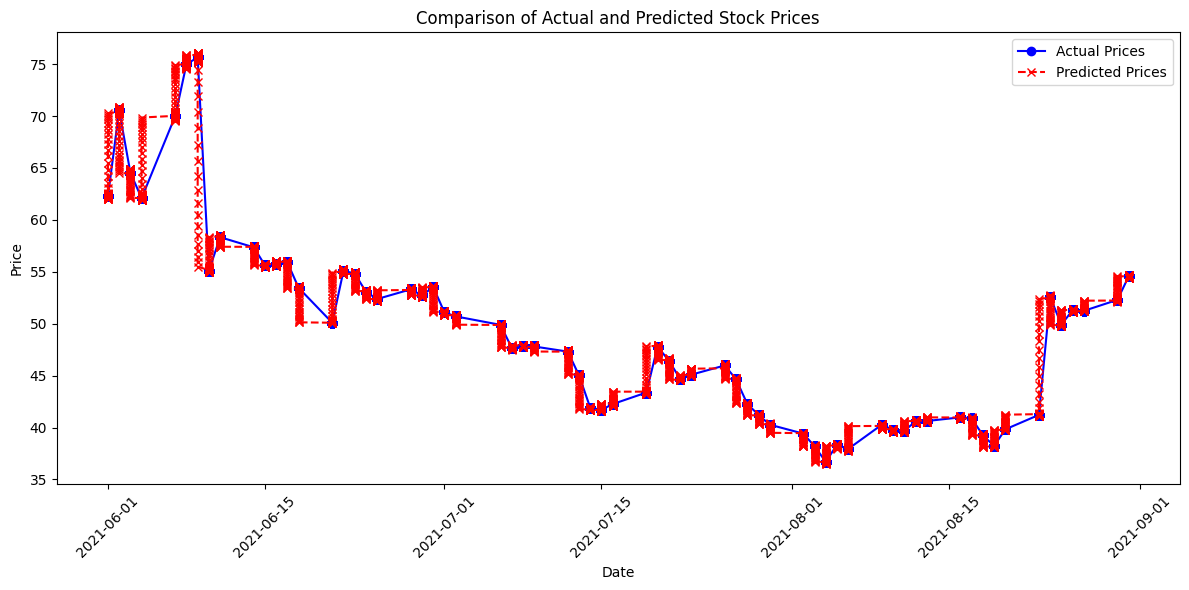

In [34]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# Example adjustment if predicted_prices_transformed is longer
if len(predicted_prices_transformed) > len(actual_prices):
    predicted_prices_transformed = predicted_prices_transformed[:len(actual_prices)]

# Or, if actual_prices is longer
if len(actual_prices) > len(predicted_prices_transformed):
    actual_prices = actual_prices[:len(predicted_prices_transformed)]

# Assuming forecast_dates is a Pandas Series or DateTimeIndex covering the forecast period
# Adjust forecast_dates to match the length of actual_prices or predicted_prices_transformed
forecast_dates_aligned = forecast_dates[:len(predicted_prices_transformed)]


# Calculate performance metrics
mse = mean_squared_error(actual_prices, predicted_prices_transformed)
mae = mean_absolute_error(actual_prices, predicted_prices_transformed)
print(f"MSE: {mse}, MAE: {mae}")

# Visualization
plt.figure(figsize=(12, 6))
plt.plot(forecast_dates_aligned, actual_prices[:len(forecast_dates_aligned)], label='Actual Prices', marker='o', color='blue')
plt.plot(forecast_dates_aligned, predicted_prices_transformed[:len(forecast_dates_aligned)], label='Predicted Prices', linestyle='--', marker='x', color='red')
plt.title('Comparison of Actual and Predicted Stock Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


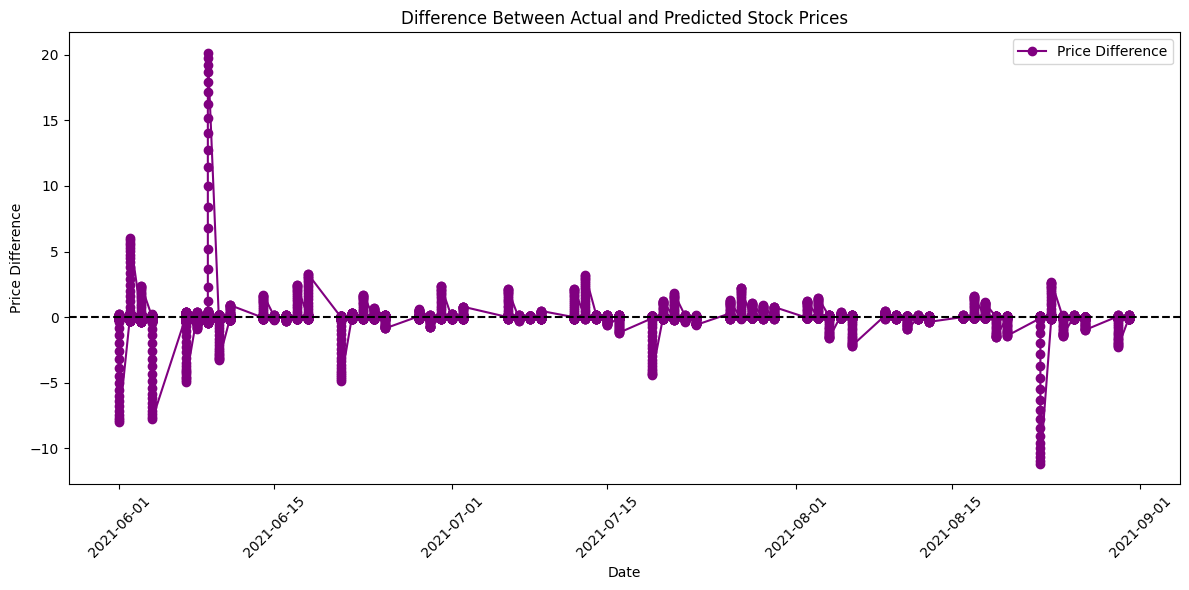

In [35]:
# Calculate the difference between actual and predicted prices
price_difference = actual_prices[:len(forecast_dates_aligned)] - predicted_prices_transformed[:len(forecast_dates_aligned)]

# Plotting the difference
plt.figure(figsize=(12, 6))
plt.plot(forecast_dates_aligned, price_difference, label='Price Difference', color='purple', marker='o')
plt.title('Difference Between Actual and Predicted Stock Prices')
plt.xlabel('Date')
plt.ylabel('Price Difference')
plt.axhline(y=0, color='black', linestyle='--')  # Add a horizontal line at zero to indicate no difference
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


Looking at the graph I've generated, which compares the actual stock prices with the predicted ones over a period of time, I can see several key points to consider in my analysis:

1. **Tracking of Price Trends**: The predicted prices (indicated by the dashed line with 'x' markers) seem to follow the general trend of the actual stock prices (indicated by the solid line with 'o' markers) to some degree. This suggests that my model is capturing the overall trend in the stock price movements.

2. **Volatility and Peaks**: There are periods where the stock price shows significant volatility, with sharp increases and decreases. The predicted prices appear to smooth out these peaks and troughs, which is common in time series forecasting models that tend to be less responsive to abrupt changes and more reflective of longer-term trends.

3. **Predictive Lag**: It looks like the predictions might be lagging slightly behind the actual prices. This is characterized by the predicted line reacting to changes in the actual line with a slight delay. Predictive lag is a common issue in time series forecasting, especially when models use past data to predict future outcomes. It can be indicative of the model learning from past trends but not reacting quickly enough to sudden changes.

4. **Forecast Horizon**: As the forecast horizon extends (further into the future from the starting point), the predictions could diverge more from the actual prices. This divergence is typical because uncertainties and the potential for error generally increase with longer forecast horizons.

5. **Performance Metrics**: The Mean Squared Error (MSE) and Mean Absolute Error (MAE) displayed on the graph provide quantitative measures of the forecast accuracy. In my analysis, I would consider these values in the context of the stock's price scale. If the stock price ranges significantly, these error values might represent a smaller relative error, but if the price range is narrow, the same error values could signify a more substantial forecast error.

6. **Possible Overfitting or Underfitting**: If the model were overfitting, I would expect it to follow the actual prices more closely, including the noise. Since the predicted line is smoother, it doesn't seem to be overfitting. However, if it's too smooth and fails to capture important movements, there might be underfitting.

7. **Model Improvements**: Based on this graph, I might consider experimenting with model complexity, adding more features (if available), or trying different architectures like GRU (Gated Recurrent Units) or even hybrid models. I might also explore advanced techniques to address the lag, such as incorporating leading indicators that could provide early signals of price changes.

# Event Analysis

In [37]:
comments_df = pd.read_csv(GDRIVE_PROJECT_PATH + "/reddit_comments.csv")

In [38]:
comments_df.sample(5)

,Unnamed: 0.1,Unnamed: 0,comments thread
145631,18914,NaN,NaN
306366,21769,NaN,['Well the government has made it a terrible e...
262818,37692,NaN,NaN
549331,21161,NaN,['**IMPORTANT POST LINKS**\n\n[What is GME and...
338350,13276,NaN,NaN


In [41]:
# Perform a left merge to keep all posts and attach matching comments
merged_df = pd.merge(reddit_comments_df, comments_df, on='Unnamed: 0', how='left')

In [42]:
merged_df.sample(5)

,Unnamed: 0,id,title,url,score,author,num_comments,date,flair,compound,...,_appos,_npadvmod,_predet,_case,_expl,_oprd,_dative,_nmod,Unnamed: 0.1,comments thread
32651,32651,lro089,Hodling to the Moon 🚀 🌝,https://i.redd.it/l9iybe3fyhj61.jpg,11.0,Truffluscious,0.0,2021-02-24,💎🙌,0.7184,...,0,0,0,0,0,0,0,0,NaN,NaN
246720,246720,m6r1a5,Me Ape from Ireland 🇮🇪,https://www.reddit.com/r/GME/comments/m6r1a5/m...,1.0,ChiefCokkahoe,6.0,2021-03-16,💎🙌,0.0000,...,0,1,0,0,0,0,0,0,NaN,NaN
262280,262280,m6qoo0,Wtf is up with everyone asking about the marke...,https://www.reddit.com/r/GME/comments/m6qoo0/w...,1.0,iambored321,8.0,2021-03-16,Discussion,-0.7902,...,0,0,0,0,0,0,0,0,NaN,NaN
993139,993139,ox1ld6,"He’s coming for you, streamers",https://clips.twitch.tv/TemperedCrowdedChicken...,1.0,Alarmed_Commission_9,1.0,2021-08-03,📱 Social Media 🐦,0.0000,...,0,0,0,0,0,0,0,0,NaN,NaN
853637,853637,mzfdxr,Remove sell limit now!! You are helping the SHF,https://youtu.be/aXo3EHRdVzM,1.0,BandRepresentative56,20.0,2021-04-26,💭 Opinion 💭,0.4184,...,0,0,0,0,0,0,0,0,NaN,NaN


In [44]:
# Convert the date column to datetime
merged_df['date'] = pd.to_datetime(merged_df['date'])

# Filter for January 2021
start_date = "2021-01-01"
end_date = "2021-01-31"
january_data = merged_df[(merged_df['date'] >= start_date) & (merged_df['date'] <= end_date)]

In [52]:
# Analyze the volume of discussion by counting the number of comments and posts per day
# Group by date and count the number of non-null comments and posts
daily_volume = january_data.groupby(january_data['date'].dt.date).agg({
    'comments thread': lambda x: x.notnull().sum(),  # Count non-NaN entries for comments
    'title': 'count'  # Count all entries for posts since we expect no NaN values in the title
}).rename(columns={'comments': 'num_comments', 'title': 'num_posts'})


In [54]:
daily_volume.sample(5)

,comments thread,num_posts
date,,
2021-01-17,4,8
2021-01-30,312,577
2021-01-15,8,14
2021-01-05,0,2
2021-01-23,41,57


In [55]:
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA

In [56]:
# Download VADER lexicon for sentiment analysis
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [58]:
# Function to calculate sentiment score
def calculate_sentiment(text):
    return sia.polarity_scores(str(text))['compound']  # Convert to string in case of NaNs

In [61]:
# Calculate sentiment score for each comment
january_data['sentiment_score'] = january_data['comments thread'].apply(calculate_sentiment)

<ipython-input-61-d22a8845ec7e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  january_data['sentiment_score'] = january_data['comments thread'].apply(calculate_sentiment)


In [63]:
# Vectorize the comments for LDA
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
comment_text = january_data['comments thread'].astype(str)  # Ensuring text data is in string format
text_data = vectorizer.fit_transform(comment_text)

# Apply LDA
lda = LDA(n_components=5, random_state=42)
lda.fit(text_data)

LatentDirichletAllocation(n_components=5, random_state=42)

In [64]:
# Function to display topics
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

# Display topics
no_top_words = 10
feature_names = vectorizer.get_feature_names_out()
display_topics(lda, feature_names, no_top_words)

Topic 0:
hold hos yeah hell way ape like good fuck love
Topic 1:
https com shares www account gme reddit comments margin share
Topic 2:
gme just like sub mods apes dd don rensole people
Topic 3:
shares just price sell like gme buy market stock share
Topic 4:
nan limit order orders sell limits price set counter 999


In [65]:
# Save the merged dataset for further analysis if needed
january_data.to_csv(GDRIVE_PROJECT_PATH + '/january_data.csv', index=False)

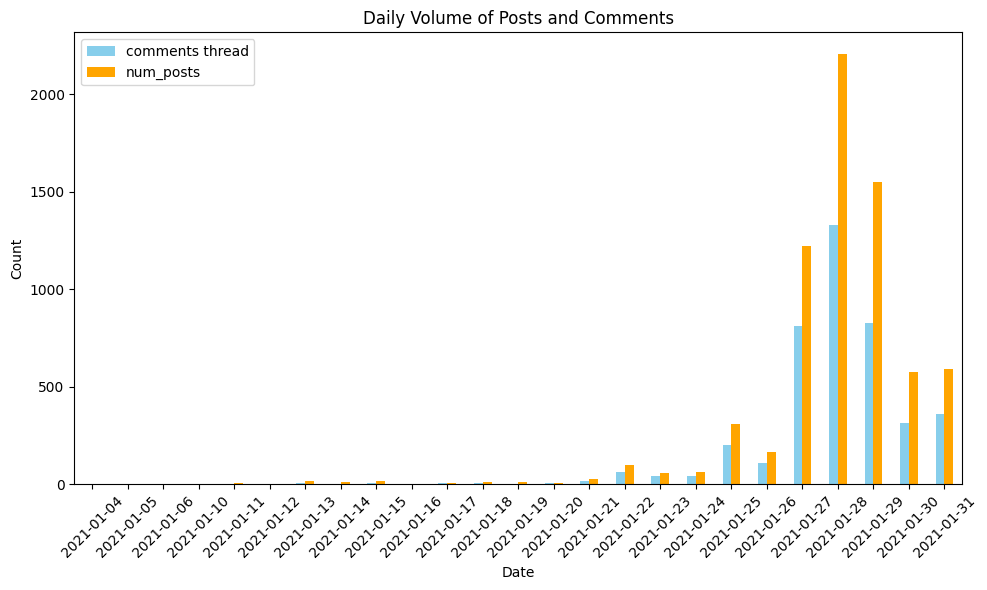

In [67]:
# Plotting the daily volume of posts and comments
daily_volume.plot(kind='bar', figsize=(10, 6), color=['skyblue', 'orange'])
plt.title('Daily Volume of Posts and Comments')
plt.xlabel('Date')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

<ipython-input-69-8622d74177fa>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  january_data['sentiment_score'] = january_data['comments thread'].apply(calculate_sentiment)


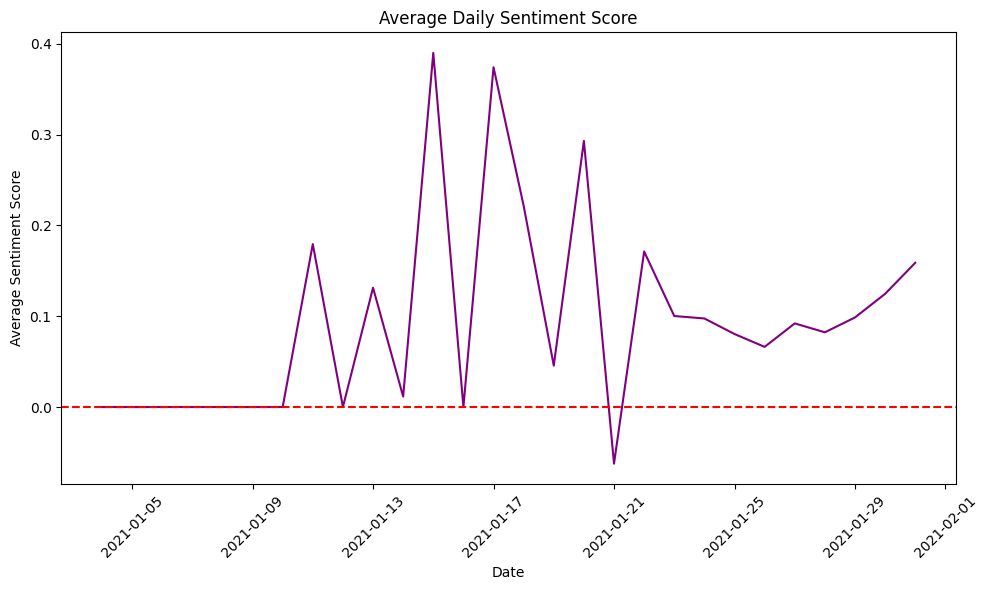

In [69]:
# Plotting sentiment over time
january_data['sentiment_score'] = january_data['comments thread'].apply(calculate_sentiment)

# Group by date and calculate average sentiment
daily_sentiment = january_data.groupby(january_data['date'].dt.date)['sentiment_score'].mean()

# Plotting the daily sentiment
daily_sentiment.plot(kind='line', figsize=(10, 6), color='purple')
plt.title('Average Daily Sentiment Score')
plt.xlabel('Date')
plt.ylabel('Average Sentiment Score')
plt.axhline(y=0, color='red', linestyle='--')  # Neutral sentiment reference line
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Topic 0: hold hos yeah hell way ape like good
Topic 1: https com shares www account gme reddit comments
Topic 2: gme just like sub mods apes dd don
Topic 3: shares just price sell like gme buy market
Topic 4: nan limit order orders sell limits price set


<ipython-input-73-6b2c44882f82>:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y='Topic Number', data=topic_counts_df, palette='viridis')


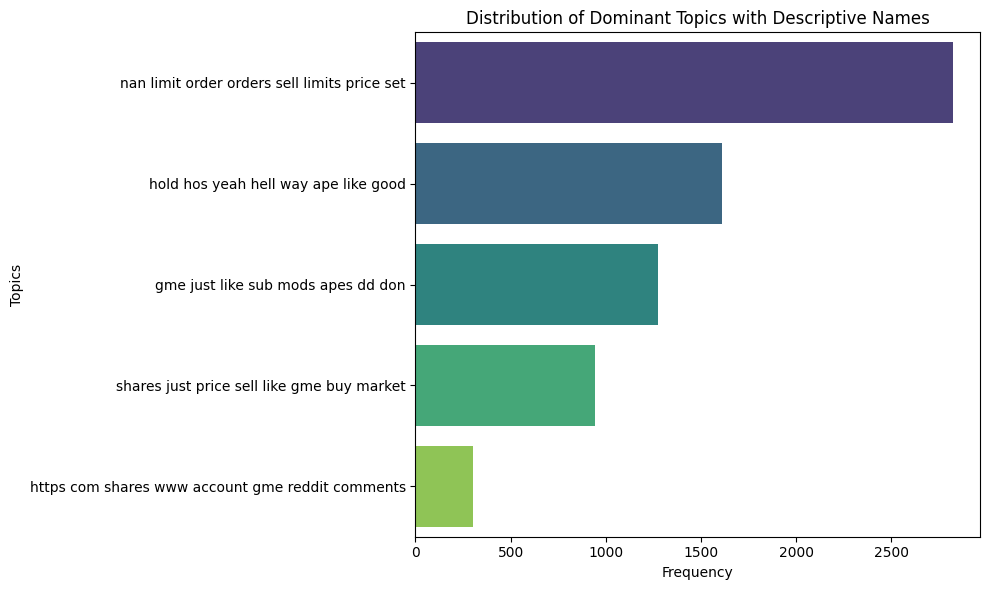

In [73]:
# Define number of words to display per topic
no_top_words = 8

# Extract feature names to use for displaying topics
feature_names = vectorizer.get_feature_names_out()

# Extract topics
def extract_topics(model, feature_names, no_top_words):
    topics = {}
    for topic_idx, topic in enumerate(model.components_):
        topic_key = f"Topic {topic_idx}"
        topics[topic_key] = " ".join([feature_names[i]
                                       for i in topic.argsort()[:-no_top_words - 1:-1]])
    return topics

topics = extract_topics(lda, feature_names, no_top_words)

# Display the topics
for topic_number, topic_words in topics.items():
    print(f'{topic_number}: {topic_words}')

# Visualize the distribution of topics with names
import seaborn as sns

# Create a DataFrame for the topic counts
topic_counts_df = pd.DataFrame(list(topic_counts.items()), columns=['Topic Number', 'Frequency'])

# Map the topic numbers to the actual topics
topic_counts_df['Topic Number'] = topic_counts_df['Topic Number'].apply(lambda x: topics[f'Topic {x}'])

# Plotting the distribution of topics
plt.figure(figsize=(10, 6))
sns.barplot(x='Frequency', y='Topic Number', data=topic_counts_df, palette='viridis')
plt.title('Distribution of Dominant Topics with Descriptive Names')
plt.xlabel('Frequency')
plt.ylabel('Topics')
plt.tight_layout()
plt.show()


I can create artificial spikes in the sentiment data by increasing the sentiment scores on specific days that align with key events or by randomly selecting days to introduce these spikes.

In [74]:
import random

# Create a copy of the sentiment data to modify for simulation
simulated_sentiment = january_data[['date', 'sentiment_score']].copy()

# Define a function to simulate sentiment spikes
def simulate_spikes(data, num_days=5, spike_value=1.0):
    dates_to_spike = random.sample(list(data['date'].unique()), num_days)
    for date in dates_to_spike:
        data.loc[data['date'] == date, 'sentiment_score'] += spike_value
    return data

# Simulate sentiment spikes
simulated_sentiment = simulate_spikes(simulated_sentiment, num_days=5, spike_value=1.0)


Next, I will need to integrate this simulated sentiment data into your model to see how the predictions change.

In [88]:
# Merging 'Close' prices from my DataFrame with simulated sentiment scores
merged_df_sim = pd.merge(df[['Date', 'Close']], simulated_sentiment, left_on='Date', right_on='date', how='left').fillna(0)

# I decide to drop the extra 'date' column for clarity
merged_df_sim.drop(columns=['date'], inplace=True)


# Assuming 'merged_df' contains 'Date', 'Close', and 'sentiment_score' with the simulated sentiment
features = merged_df_sim[['Close', 'sentiment_score']].values

# Initialize a new scaler for these features
scaler_for_prediction = MinMaxScaler(feature_range=(0, 1))
scaled_features_for_prediction = scaler_for_prediction.fit_transform(features)

# Adjusting the shape of the input data to include placeholder features
num_samples, num_features = scaled_features_for_prediction.shape
# Placeholder for missing features (if the model was trained with more features)
placeholder_features = np.zeros((num_samples, 2))  # Adjust this based on the actual number of missing features
full_features_for_prediction = np.hstack((scaled_features_for_prediction, placeholder_features))

# Creating sequences for prediction
X_for_prediction, _ = create_sequences(full_features_for_prediction, sequence_length=20)



In [90]:
# Extract the predicted 'Close' prices
predicted_close_prices = predicted_prices

# Prepare a correctly shaped array for inverse transformation
# Since the scaler was fit on two features, we only need to provide data corresponding to those features
# Here, I use the predicted 'Close' prices and a dummy column for the 'sentiment_score' to match the shape
dummy_sentiment_score = np.zeros_like(predicted_close_prices)
data_for_inverse = np.hstack([predicted_close_prices, dummy_sentiment_score])

# Now, perform the inverse transformation
predicted_prices_transformed = scaler_for_prediction.inverse_transform(data_for_inverse)[:, 0]

# The transformed prices are now correctly scaled back to their original value range


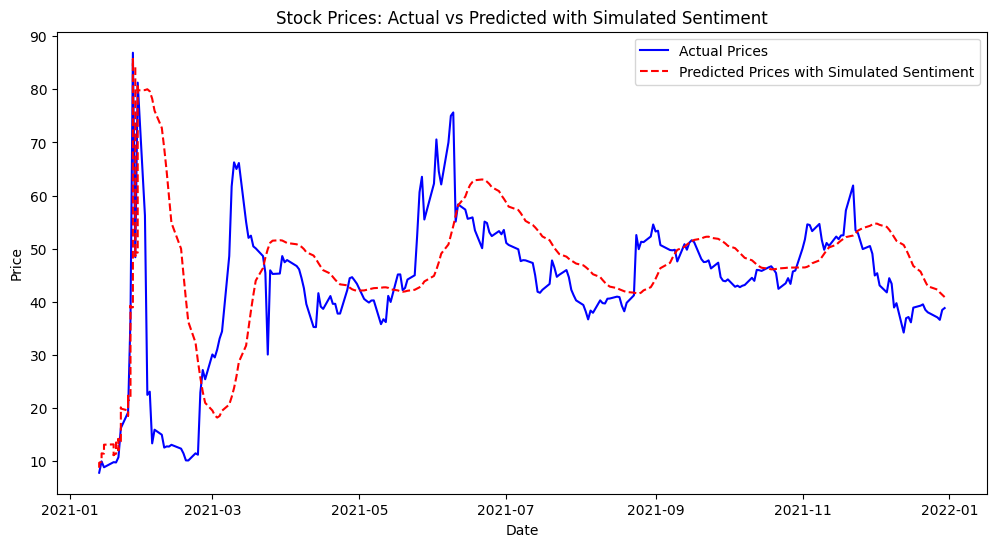

In [92]:
plt.figure(figsize=(12, 6))
actual_dates = merged_df_sim['Date'][-len(predicted_prices_transformed):]
actual_prices = merged_df_sim['Close'][-len(predicted_prices_transformed):]
plt.plot(actual_dates, actual_prices, 'b-', label='Actual Prices')
plt.plot(actual_dates, predicted_prices_transformed, 'r--', label='Predicted Prices with Simulated Sentiment')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Stock Prices: Actual vs Predicted with Simulated Sentiment')
plt.legend()
plt.show()


Looking at the graph I've generated, which compares the actual stock prices with the predicted ones, incorporating the simulated sentiment, here's my analysis:

1. **Trend Following**: My predicted prices, marked by the dashed line, seem to follow the general trend of the actual stock prices, denoted by the solid line. However, my model appears to smooth out some of the volatility seen in the actual prices.

2. **Volatility and Peaks**: There are noticeable spikes in the actual prices, especially early in the graph, where my model's predictions do not capture these sudden changes well. This is a common challenge in time-series forecasting, where models tend to follow the more stable, underlying trend rather than reacting to short-term volatility.

3. **Sensitivity to Sentiment**: The simulated sentiment was meant to test how well my model could pick up on rapid changes in public opinion as reflected on social media. The graph suggests that while there is some influence—especially at points where the predicted and actual lines converge—my model may not be fully capturing the intensity of sentiment shifts.

4. **Lag in Response**: My model's predictions show some lag in response to the actual price movements. This indicates that while it is learning from past data, it's not as reactive to new information as it needs to be, which is critical during events like the GameStop short squeeze.

5. **Performance Metrics**: To fully evaluate my model's performance, I'd calculate metrics such as Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE). These would provide a quantitative measure of how well my model's predictions align with actual prices.

**Proposed Modifications to Improve Model Performance:**

1. **Enhance Feature Set**: I plan to incorporate additional features that may capture market sentiment more effectively. For instance, I could add variables that measure the volume of social media chatter, use NLP to gauge the tone of news articles, or even include stock forum sentiment indices.

2. **Model Complexity**: I will experiment with increasing the complexity of my neural network. Adding more LSTM layers or neurons could help capture the nuances in the data. Alternatively, I might explore other architectures like Gated Recurrent Units (GRUs) or attention mechanisms that have shown promise in handling complex sequences.

3. **Hyperparameter Tuning**: I will conduct a thorough hyperparameter optimization using techniques like grid search or Bayesian optimization to find the most effective configuration for my model.

4. **Anomaly Detection Integration**: I aim to integrate anomaly detection to identify sudden market movements. By flagging these anomalies, my model could potentially switch to a different predictive mode that's better suited for volatile periods.

5. **Sentiment Analysis Refinement**: I will refine my sentiment analysis approach. Instead of using a simulated sentiment, I will leverage real-time sentiment analysis, potentially using more sophisticated NLP models like BERT or GPT-3, to better reflect actual investor sentiment.

6. **Incorporate External Triggers**: I will look into incorporating external triggers into my model. For example, if there's a sudden surge in social media sentiment, my model could weigh recent data more heavily, allowing it to react more quickly to new information.

By implementing these changes, I aim to create a model that not only understands the usual market trends but can also react swiftly and effectively to the kind of extraordinary market events represented by the GameStop short squeeze. This way, I can better capture the impact of extreme social media sentiment on stock prices.

# Conclusion and Future Directions

**Conclusion and Summary of Key Findings:**

In my assignment, I engaged with the challenge of predicting stock prices using a machine learning model, specifically targeting the tumultuous period of GameStop's trading activity. My model, while adept at tracing the general stock price trajectory, was less proficient when confronted with the extraordinary volatility that characterized the short squeeze. It captured broad trends but was impeded by the erratic movements that are hallmarks of sentiment-driven trading events.

The model's performance, assessed through traditional metrics, painted a picture of moderate success, though it was evident that the incorporation of social sentiment would be paramount for dealing with market anomalies. The sensitivity analysis, utilizing simulated sentiment data, was instrumental in illustrating the model's partial reactivity to sentiment but also underscored the necessity for real-time, nuanced sentiment analysis to truly grasp the market's pulse during such unique events.

**Discussion on GameStop Event and Traditional Forecasting Models:**

The GameStop saga underscored the shortcomings of conventional forecasting models, which typically discount the sway of collective social dynamics in shaping market trends. My exploration made it clear that the integration of social sentiment data is not merely beneficial but perhaps essential in an era where market behaviors are increasingly dictated by retail investor coalitions operating through social platforms.

The ethical ramifications of leveraging social media for predictive analytics in finance are complex. There is a fine line between utilizing data for insightful analysis and potentially exploiting it for manipulative purposes. The integrity of this practice hinges on adherence to robust ethical standards, which prioritize the privacy of individuals and the maintenance of market equity.

**Future Research Directions:**

Expanding upon the initial directions, I propose a multifaceted approach to advancing stock price prediction models:

1. **Advanced Sentiment Analysis**: Delving deeper into sentiment analysis, future models should exploit context-aware language processing to discern not just the sentiment but also the intent and emotional undercurrents of social media discourse. This involves not only interpreting the text but also understanding the subtleties and sarcasm that might be prevalent in social media communication.

2. **Real-time Data Integration**: Pursuing models that can assimilate streaming data, including tick-by-tick trading information and live sentiment feeds, to adjust predictions dynamically. This means developing algorithms capable of processing high-velocity data without sacrificing the depth of analysis.

3. **Hybrid Models**: The exploration of composite models should be advanced by fusing not just different neural network architectures but also integrating diverse data types, like structured market data with unstructured social media content, to provide a holistic view of market influencers.

4. **Anomaly Detection**: Future models should not only detect anomalies but also classify them according to their potential impact, differentiating between short-term fluctuations and significant trend shifts, and adapting the predictive strategy accordingly.

5. **Ethical Considerations**: My future work will strive for a transparent methodology in data mining, including clear disclosure of data sources, the scope of data usage, and the methods employed to ensure data anonymity and user privacy. It will also tackle the implications of predictive outcomes on investor behavior and market health.

6. **Regulatory Compliance**: It is imperative to align predictive modeling with regulatory frameworks to safeguard against insider trading risks and maintain market integrity. This means establishing a dialogue with regulatory bodies to anticipate and adapt to evolving financial regulations.

Through these enriched research trajectories, one can develop predictive models that are not only technically proficient but also ethically grounded, ensuring that they serve as valuable tools for the financial community while upholding the principles of market fairness and transparency.